In [ ]:
%matplotlib inline
import nbimport
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse.linalg as spla
np.set_printoptions(linewidth=130)

In [2]:
from fsmfuncs import *
from ibmfuncs import *
from gridfuncs import *

importing Jupyter notebook from fsmfuncs.ipynb
importing Jupyter notebook from ibmfuncs.ipynb
importing Jupyter notebook from gridfuncs.ipynb


Numerical grid for the fluid

In [3]:
x = np.linspace(-1.10, 1.10, 129)
y = np.linspace(-1.10, 1.10, 129)

n, m = len(y)-1, len(x)-1

dy, dx = np.diff(y), np.diff(x)
dxmin = min(np.min(dx), np.min(dy))

yp, xp = 0.5*(y[1:] + y[:-1]), 0.5*(x[1:] + x[:-1])
dyp, dxp = np.diff(yp), np.diff(xp)
p = np.zeros( (n, m) )

yu, xu = yp, x[1:-1]
u = np.zeros( (n, m-1) )

yv, xv = y[1:-1], xp
v = np.zeros( (n-1, m) )

Immersed boundary

In [4]:
r_ = 1.0
l1 = int((2*np.pi*r_)/dxmin)
ang_ = 2*np.pi*np.arange(l1)/l1
xi1 = 0 + r_*np.cos(ang_)
eta1 = 0 + r_*np.sin(ang_)
ds1 = 2*np.pi*r_/l1*np.ones(l1)
uB1 = np.zeros_like(xi1)
vB1 = np.zeros_like(xi1)

r_ = 0.5
l2 = int((2*np.pi*r_)/dxmin)
ang_ = 2*np.pi*np.arange(l2)/l2
xi2 = 0 + r_*np.cos(ang_)
eta2 = 0 + r_*np.sin(ang_)
ds2 = 2*np.pi*r_/l2*np.ones(l2)
uB2 = -np.sin(ang_)
vB2 = np.cos(ang_)

xi = np.concatenate([xi1, xi2])
eta = np.concatenate([eta1, eta2])
ds = np.concatenate([ds1, ds2])
uB = np.concatenate([uB1, uB2])
vB = np.concatenate([vB1, vB2])
l = l1+l2

Plot grid and immersed boundary

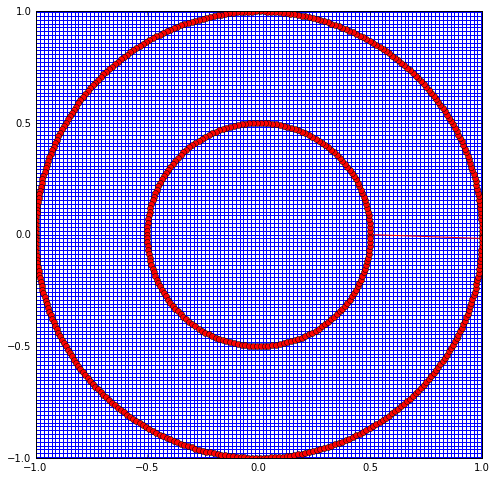

In [5]:
plt.figure(figsize=(8,8))
X, Y = np.meshgrid(x, y)
plt.plot(X, Y, 'b-');
plt.plot(X.T, Y.T, 'b-');
plt.plot(xi, eta, 'ro-');
plt.xlim(-1, 1);
plt.ylim(-1, 1);

Build matrices (I)

In [6]:
G, DuW, DuE, DvS, DvN = gradient(dxp, dyp)
R, iR = weight (dx, dy)
Mh, iMh = mass_hat (dxp, dyp)
Lh, Lux0, Lux1, Luy0, Luy1, Lvx0, Lvx1, Lvy0, Lvy1 = laplacian_hat(dx, dy, dxp, dyp)
Eh = interpolation_hat(xi, eta, ds, x, y, xp, yp, dx, dy, dxp, dyp)
Hh = regularization_hat(xi, eta, ds, x, y, xp, yp, dx, dy, dxp, dyp)

E = Eh.dot(iR)
H = Mh.dot(Hh)

L = Mh.dot(Lh.dot(iR))

M = Mh.dot(iR)
iM = R.dot(iMh)

EET = E.dot(E.T)
EH = E.dot(H).tocsc()
iEH = spla.factorized(EH)

iML = iM.dot(L)
Q = sp.hstack([G, E.T])

Build matrices (II)

In [14]:
iRe = 1.0
dt = 0.75 * np.min(dxmin**2/iRe, dxmin)
print(dt, dxmin**2/iRe, dxmin)

0.000221557617187 0.00029541015625 0.0171875


In [15]:
A = (M/dt - 0.5*iRe*L).tocsc()
B = (M/dt + 0.5*iRe*L).tocsr()

iA = spla.factorized(A)

BN = dt*iM + (0.5*iRe)*dt**2*iML.dot(iM) + (0.5*iRe)**2*dt**3*iML.dot(iML.dot(iM))
QTBNQ = Q.T.dot(BN.dot(Q)).tocsc()
iQTBNQ = spla.factorized(QTBNQ)

In [16]:
uS, uN = np.zeros(m-1), np.zeros(m-1)
uE, uW = np.zeros(n), np.zeros(n)

vS, vN = np.zeros(m), np.zeros(m)
vE, vW = np.zeros(n-1), np.zeros(n-1)

u[:,:]=0
v[:,:]=0

q = R.dot(np.concatenate([u.ravel(), v.ravel()]))
qast = q.copy()

Num1, Nvm1 = advection_hat(dx, dy, dxp, dyp, iR.dot(q),  uS, uN, uW, uE, vS, vN, vW, vE)
Nu, Nv = Num1, Nvm1

In [17]:
nt = int(0.25/dt)

residuals = np.zeros(nt)
CFx = np.zeros(nt)
CFy = np.zeros(nt)

for k in range(nt):    
    ru = iRe*(Lux0.dot(uW) + Lux1.dot(uE) + Luy0.dot(uS) + Luy1.dot(uN)) - 1.5*Nu + 0.5*Num1
    rv = iRe*(Lvx0.dot(vW) + Lvx1.dot(vE) + Lvy0.dot(vS) + Lvy1.dot(vN)) - 1.5*Nv + 0.5*Nvm1
    
    bc1 = Mh.dot(np.concatenate([ru, rv]))
    r1 = B.dot(q.ravel()) + bc1

    qast = iA(r1)
    
    bc2 = - (DuW.dot(uW*dxp[0]) + DuE.dot(uE*dxp[-1]) + DvS.dot(vS*dyp[0]) + DvN.dot(vN*dyp[-1]))
    r2 = np.concatenate([-bc2, uB, vB])

    λ = iQTBNQ(Q.T.dot(qast) - r2)

    qp1 = qast - BN.dot(Q.dot(λ))
    
    residuals[k] = la.norm(qp1-q)/la.norm(qp1)
    f = -iEH(EET.dot(λ[n*m:]))
    F = -H.dot(f)
    Fx, Fy = F[:n*(m-1)].reshape((n, m-1)), F[n*(m-1):].reshape((n-1,m))
    CFx[k] = 2*np.sum(Fx*dxp[np.newaxis,:]*dy[:,np.newaxis])
    CFy[k] = 2*np.sum(Fy*dx[np.newaxis,:]*dyp[:,np.newaxis])    
    
    if k%100==0:
        print(k, k*dt, residuals[k], CFx[k], CFy[k])
    
    q = qp1
    Num1, Nvm1 = Nu, Nv
    Nu, Nv = advection_hat(dx, dy, dxp, dyp, iR.dot(q), uS, uN, uW, uE, vS, vN, vW, vE)


0 0.0 1.0 -2.90434343242e-13 0.00376225361413
100 0.0221557617187 0.00321921909708 -2.57935681203e-07 -0.000123277901311
200 0.0443115234375 0.00097938161617 -1.89874213602e-07 -0.000306941190401
300 0.0664672851562 0.000344232153418 -1.71869880772e-07 -0.000384761086369
400 0.088623046875 0.000128894380463 -1.66820539868e-07 -0.000415401914857
500 0.110778808594 4.97029949427e-05 -1.65316572778e-07 -0.000427441266336
600 0.132934570312 1.94252795369e-05 -1.64848684189e-07 -0.000432179360753
700 0.155090332031 7.63816002893e-06 -1.64697087246e-07 -0.000434046460841
800 0.17724609375 3.01159091977e-06 -1.64646053014e-07 -0.000434782872867
900 0.199401855469 1.18887520657e-06 -1.64628228994e-07 -0.000435073502312
1000 0.221557617187 4.69587581371e-07 -1.64621803495e-07 -0.000435188248515
1100 0.243713378906 1.85526213858e-07 -1.64619473525e-07 -0.000435233565353


In [18]:
iRq = iR.dot(q)
u, v = iRq[:n*(m-1)].reshape((n, m-1)), iRq[n*(m-1):].reshape((n-1, m))
p = λ[:n*m].reshape((n,m))
f = λ[n*m:]

Display solution

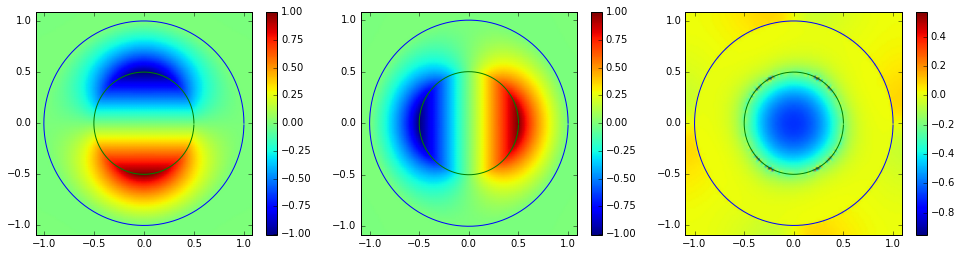

In [19]:
plt.figure(figsize=(5.5*3,4))
plt.subplot(1,3,1)
plt.pcolormesh(xu, yu, u, shading='gouraud')
plt.plot(xi1, eta1, lw=1)
plt.plot(xi2, eta2, lw=1)
plt.xlim(xu[0], xu[-1])
plt.ylim(yu[0], yu[-1])
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(xv, yv, v, shading='gouraud')
plt.plot(xi1, eta1, lw=1)
plt.plot(xi2, eta2, lw=1)
plt.xlim(xv[0], xv[-1])
plt.ylim(yv[0], yv[-1])
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(xp, yp, p, shading='gouraud')
plt.plot(xi1, eta1, lw=1)
plt.plot(xi2, eta2, lw=1)
plt.xlim(xp[0], xp[-1])
plt.ylim(yp[0], yp[-1])
plt.colorbar()

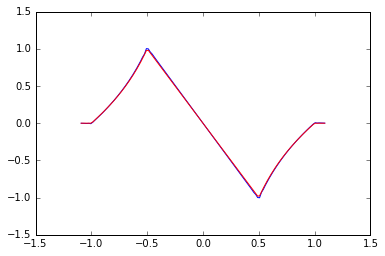

In [20]:
def vr_exact(r, w1, R1, R2):
    if np.abs(r)<=R1:
        return w1*r
    elif R1<=np.abs(r)<=R2:
        return -R1**2*w1/(R2**2-R1**2)*r + w1/(R2**2-R1**2)*R1**2*R2**2/r
    else:
        return 0

plt.plot(yu, u[:, (m-1)//2]);
plt.plot(yu, [vr_exact(yk, -2.0, 0.5, 1.0) for yk in yu], 'r')